# Cycle Aging Mechanism

<p align="center">
  <img src="../docs/figures/03_cycle_aging_predictor.png" alt="Cycle Aging Predictor" width="600"/>
</p>

The cycle aging mechanism in batteries refers to the degradation of battery performance over time due to repeated charge and discharge cycles. This process is influenced by several factors, including the State of Charge (SOC), depth of cycle (DOC), charge and discharge rates, and operating temperatures.

In each charge-discharge cycle, the battery undergoes structural changes in its electrodes, leading to a gradual loss of capacity. Key phenomena contributing to cycle aging include the growth of the solid electrolyte interphase (SEI) on the anode, lithium plating, and mechanical stress within the electrodes. Over time, these changes result in increased internal resistance, reduced charge acceptance, and ultimately, a decline in the battery’s overall capacity.

The depth of cycle is particularly critical; deeper discharges cause more significant wear on the battery, accelerating aging. Similarly, high charge and discharge rates generate more heat, which exacerbates degradation processes. Operating temperatures also play a vital role; while moderate temperatures are generally safe, extreme temperatures (both high and low) can accelerate aging.

Accurate prediction and understanding of cycle aging are essential for optimizing battery performance, extending its lifespan, and ensuring reliability in applications ranging from consumer electronics to electric vehicles and energy storage systems. This notebook explores the cycle aging mechanism and applies probabilistic deep learning models to predict battery degradation, enhancing the ability to manage and mitigate aging effects.

## Environment Setup and Module Imports

In the following cell, we set up the environment by configuring the system paths to include necessary directories. This allows us to import custom modules used for battery aging analysis. We also set up the visualization defaults using the `seaborn` library and ensure that all plots are displayed inline within the notebook.

Additionally, the path to the dataset directory is constructed, and a `MatlabFileReader` object is initialized to load the cycle aging data. This setup is essential for the analysis that follows.

In [ ]:
import os
import sys
from pathlib import Path

myDir = os.getcwd()
sys.path.append(myDir)
path = Path(myDir)
parent=str(path.parent.absolute())
sys.path.append(parent)
sys.path.append(os.path.join(parent, "scripts"))

from src.common.matlab_interface import MatlabFileReader
from src.common.utils import *
from src.lfp.cycle_aging import CycleAging

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

directory_path = os.path.join(parent, "dataset", "data_cycle")

reader = MatlabFileReader(directory_path)

The following cell checks whether a GPU is available for TensorFlow to use.

In [15]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

## Importing and Combining Aging Data

In the following cell, we import multiple datasets related to battery aging, encompassing both calendar and cycle aging effects. The data is sourced from different [MATLAB files](https://data.mendeley.com/datasets/6hgyr25h8d/1), each focusing on specific static conditions such as Depth of Discharge (DoD), charge and discharge rates, temperature, and state of charge (SOC).

The imported data is processed and combined into a single DataFrame to facilitate comprehensive analysis. We ensure that duplicate columns are renamed to maintain uniqueness, and columns with missing data are removed to retain only fully populated data entries. The resulting DataFrame, `df_comb`, will be used for further analysis in the following steps.


In [16]:
file_name = "xCyC_80DOD_40_C_Capacity_CC_CV_FEC.mat"
data_c_rate = reader.read_matfile(file_name, source_name="Naumann")
df_comb_c_rate = reader.extract_data_in_df(mat_data=data_c_rate)
##########################################
file_name = "xDOD_1C1C_40_C_Capacity_CC_CV_FEC.mat"
data_dod = reader.read_matfile(file_name, source_name="Naumann")
df_comb_dod = reader.extract_data_in_df(mat_data=data_dod)
##########################################
file_name = "xDOD_1C1C_x_C_Capacity_CC_CV_FEC.mat"
data_temp_and_dod = reader.read_matfile(file_name, source_name="Naumann")
df_comb_temp_and_dod = reader.extract_data_in_df(mat_data=data_temp_and_dod)
##########################################
file_name = "xSOC_20DOD_1C1C_40_C_Capacity_CC_CV_FEC.mat"
data_soc = reader.read_matfile(file_name, source_name="Naumann")
df_comb_soc = reader.extract_data_in_df(mat_data=data_soc)
##########################################
df_comb = pd.concat([df_comb_c_rate, df_comb_dod, df_comb_temp_and_dod, df_comb_soc], axis=1)
df_comb = rename_duplicate_columns(df_comb)
df_comb.dropna(axis=1, inplace=True)
df_comb

,x_Testpoint Cyclization_40°C_50%SOC_80%DOD_1C_1C_CC,y_Testpoint Cyclization_40°C_50%SOC_80%DOD_1C_1C_CC,y_max_Testpoint Cyclization_40°C_50%SOC_80%DOD_1C_1C_CC,y_min_Testpoint Cyclization_40°C_50%SOC_80%DOD_1C_1C_CC,x_Testpoint Cyclization_40°C_50%SOC_80%DOD_0.5C_0.5C_CC,y_Testpoint Cyclization_40°C_50%SOC_80%DOD_0.5C_0.5C_CC,y_max_Testpoint Cyclization_40°C_50%SOC_80%DOD_0.5C_0.5C_CC,y_min_Testpoint Cyclization_40°C_50%SOC_80%DOD_0.5C_0.5C_CC,x_Testpoint Cyclization_40°C_50%SOC_80%DOD_0.2C_0.2C_CC,y_Testpoint Cyclization_40°C_50%SOC_80%DOD_0.2C_0.2C_CC,...,y_max_Testpoint Cyclization_40°C_50%SOC_20%DOD_1C_1C_CC_1,y_min_Testpoint Cyclization_40°C_50%SOC_20%DOD_1C_1C_CC_1,x_Testpoint Cyclization_40°C_75%SOC_20%DOD_1C_1C_CC,y_Testpoint Cyclization_40°C_75%SOC_20%DOD_1C_1C_CC,y_max_Testpoint Cyclization_40°C_75%SOC_20%DOD_1C_1C_CC,y_min_Testpoint Cyclization_40°C_75%SOC_20%DOD_1C_1C_CC,x_Testpoint Cyclization_40°C_25%SOC_20%DOD_1C_1C_CC,y_Testpoint Cyclization_40°C_25%SOC_20%DOD_1C_1C_CC,y_max_Testpoint Cyclization_40°C_25%SOC_20%DOD_1C_1C_CC,y_min_Testpoint Cyclization_40°C_25%SOC_20%DOD_1C_1C_CC
0,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
1,79.785307,0.985343,0.986263,0.984762,39.888840,0.990664,0.990729,0.990608,15.953934,0.996132,...,0.980080,0.979624,79.393130,0.980861,0.980991,0.980772,79.636398,0.996282,0.996582,0.995999
2,137.678144,0.978726,0.979440,0.978212,68.831155,0.985575,0.985766,0.985442,27.529314,0.990091,...,0.966243,0.964960,136.953410,0.971816,0.972214,0.971208,137.433772,0.993924,0.994194,0.993707
3,203.364292,0.972912,0.974030,0.972009,101.673467,0.981226,0.981619,0.980916,40.665958,0.985782,...,0.951027,0.949005,202.372631,0.960931,0.961699,0.959869,203.166297,0.993651,0.993885,0.993334
4,352.607353,0.960789,0.962639,0.959744,176.294088,0.973619,0.973767,0.973433,70.513858,0.978919,...,0.915562,0.911656,351.352976,0.938346,0.940739,0.935821,352.454045,0.980148,0.980602,0.979512
5,502.805721,0.950743,0.952242,0.949922,251.391776,0.967289,0.967419,0.967170,100.552593,0.973360,...,0.880497,0.875211,501.298225,0.922365,0.922833,0.921798,502.622657,0.964269,0.965049,0.963750
6,640.752101,0.943020,0.944551,0.941967,320.362920,0.962618,0.962717,0.962524,128.139773,0.969428,...,0.851477,0.844667,638.996938,0.912728,0.914837,0.910893,640.540606,0.955623,0.956568,0.954881
7,970.140609,0.927218,0.928365,0.926256,485.054692,0.952862,0.953194,0.952441,194.016066,0.961645,...,0.794851,0.787938,968.138409,0.897172,0.900468,0.892235,969.898584,0.943741,0.945848,0.940932
8,1286.904998,0.915456,0.916531,0.914484,643.433473,0.944725,0.945319,0.943830,257.367083,0.955236,...,0.775894,0.758591,1284.660522,0.885682,0.888824,0.879734,1286.632101,0.937559,0.940218,0.933845
9,1640.356096,0.904306,0.905328,0.903735,820.155026,0.936850,0.937286,0.936045,328.055125,0.949766,...,0.780659,0.756391,1637.872553,0.875956,0.880444,0.869823,1640.050736,0.931957,0.934811,0.927540


## Importing and Normalizing Calendar Aging Data

The following cell imports and processes the calendar aging dataset from an [Excel file](https://data.mendeley.com/datasets/kxh42bfgtj/1). The data is cleaned by setting the first row as the column headers and dropping the original first row. The index is reset to ensure a consistent structure.

To prepare the data for analysis, the relevant columns (excluding the storage time) are normalized based on their maximum values, which scales the data to a common range for better comparability. The normalized dataset is then used for further analysis in the notebook, allowing us to explore the effects of calendar aging on battery capacity.


In [17]:
file_name_calendar = "DischargeCapacity.xlsx"
dir_calendar = os.path.join(parent, 'dataset', 'data_calendar')
file_path = os.path.join(dir_calendar, file_name_calendar)
df_calendar = pd.read_excel(file_path)
# Set the first row as the column names
df_calendar.columns = df_calendar.iloc[0]
# Drop the first row from the DataFrame
df_calendar = df_calendar.drop(df_calendar.index[0])
# Reset the index if necessary
df_calendar.reset_index(drop=True, inplace=True)
# Calculate the maximum value for each column, excluding 'C'
max_values = df_calendar.drop(columns=['Storage time / hours']).max()
# Normalize only selected columns by their maximum value
df_normalized = df_calendar.drop(columns=['Storage time / hours']) / max_values
# Add the excluded column back to the normalized DataFrame
df_normalized['Storage time / hours'] = df_calendar['Storage time / hours']
df_calendar = df_normalized
df_calendar

,"TP_0°C,50%SOC","TP_10°C,50%SOC","TP_25°C,0%SOC","TP_25°C,50%SOC","TP_25°C,100%SOC","TP_40°C,0%SOC","TP_40°C,12.5%SOC","TP_40°C,25%SOC","TP_40°C,37.5%SOC","TP_40°C,50%SOC","TP_40°C,62.5%SOC","TP_40°C,75%SOC","TP_40°C,87.5%SOC","TP_40°C,100%SOC","TP_60°C,0%SOC","TP_60°C,50%SOC","TP_60°C,100%SOC",Storage time / hours
0,1.0,1.0,0.997997,1.0,1.0,0.997901,0.997795,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,0.998428,0.997259,1.0,0.997544,0.989326,1.0,1.0,0.997164,0.995723,0.997601,0.994064,0.988179,0.984,0.985778,0.999658,0.985402,0.974359,160.33
2,0.998257,0.996598,0.99897,0.997139,0.985785,0.999667,0.999192,0.995767,0.992797,0.994927,0.991269,0.983815,0.978986,0.980651,0.996774,0.977448,0.962975,276.98
3,0.997479,0.99594,0.998404,0.995879,0.982648,0.998734,0.997353,0.993838,0.990231,0.991939,0.98849,0.980829,0.974729,0.976254,0.993941,0.971162,0.954913,408.99
4,0.996627,0.994675,0.997967,0.993794,0.978755,0.997975,0.994928,0.990357,0.986372,0.987918,0.984051,0.976173,0.968484,0.969848,0.990393,0.960497,0.942445,708.11
5,0.995428,0.993684,0.99687,0.990195,0.973172,0.996605,0.993045,0.987872,0.98306,0.984484,0.980615,0.971944,0.963392,0.964528,0.987272,0.953378,0.933912,1009.1
6,0.994464,0.992705,0.995928,0.988508,0.970365,0.995302,0.991082,0.98584,0.980255,0.981454,0.977776,0.96877,0.959281,0.960187,0.984323,0.946895,0.926379,1285.6
7,0.993641,0.991386,0.994792,0.986529,0.966334,0.993934,0.98825,0.981977,0.975606,0.976736,0.972774,0.963458,0.952505,0.953223,0.981077,0.935966,0.913511,1945
8,0.99283,0.990007,0.993918,0.984635,0.961419,0.992392,0.985602,0.978683,0.971658,0.97272,0.96867,0.959023,0.946888,0.947425,0.977956,0.927217,0.903227,2579.2
9,0.99211,0.989199,0.993131,0.98289,0.956215,0.99097,0.982981,0.975563,0.967849,0.968755,0.964676,0.954855,0.941724,0.942132,0.975202,0.920554,0.895189,3286.7


## Initializing the Cycle Aging Model

In the following cell, we initialize the `CycleAging` class, which is a custom model designed to analyze the effects of cycle aging on batteries. The class is initialized with the following parameters:

- `load_trained_models=True`: Pre-trained models are loaded, enabling us to use these models directly for analysis and predictions without needing to retrain them. [Here](../trained_models/cycle), you can find a cycle aging model trained according to the full datasets provided by TUM-EES.
- `complete_data=False`: Only a subset of the data is loaded, which can be accessed by the public. We cannot share the full datasets provided by TUM-EES.

This setup allows us to leverage existing models and selectively load data, providing flexibility in how we approach the analysis of cycle aging effects.

In [5]:
cycle_aging = CycleAging(load_trained_models=True, complete_data=False)

Loading trained model from C:\Users\heidarah\PycharmProjects\battprodeep_public\trained_models\cycle\virtual_fec.
Extracted model to temporary directory: C:\Users\heidarah\AppData\Local\Temp\tmpahjtglxy
Model directory: C:\Users\heidarah\AppData\Local\Temp\tmpahjtglxy
Model loaded from: C:\Users\heidarah\AppData\Local\Temp\tmpahjtglxy
Temporary directory deleted: C:\Users\heidarah\AppData\Local\Temp\tmpahjtglxy
Loaded model from: C:\Users\heidarah\PycharmProjects\battprodeep_public\trained_models\cycle\virtual_fec\model_20240409_172818.zip
Loading trained model from C:\Users\heidarah\PycharmProjects\battprodeep_public\trained_models\cycle\deterministic.
Extracted model to temporary directory: C:\Users\heidarah\AppData\Local\Temp\tmpizdwmn91
Model directory: C:\Users\heidarah\AppData\Local\Temp\tmpizdwmn91
Model loaded from: C:\Users\heidarah\AppData\Local\Temp\tmpizdwmn91
Temporary directory deleted: C:\Users\heidarah\AppData\Local\Temp\tmpizdwmn91
Loaded model from: C:\Users\heidarah\

## Preprocessing the Combined and Calendar Aging Data

In the following cell, we prepare the combined cycle and calendar aging data for analysis by passing it to the `preprocess_data` method of the `CycleAging` model. The data is organized into a dictionary with two keys:

- `'combined'`: Contains the dataset with both cycle and calendar aging effects.
- `'calendar'`: Contains the dataset focused solely on calendar aging.

The `preprocess_data` method is called with `interpolate_rows=False`, meaning that no interpolation will be performed to fill in missing data points. This preprocessing step is crucial for ensuring that the data is in the correct format and ready for further analysis or modeling within the `CycleAging` class.

In [6]:
data = {
    'combined': df_comb,
    'calendar': df_calendar
}
cycle_aging.preprocess_data(data, interpolate_rows=False)

Preprocessing data.


## Generating and Saving Violin Plot of Feature Distributions

In the following cell, we generate a violin plot to visualize the distribution of features in the training data used for the `CycleAging` model. The plot helps us understand the underlying patterns and densities of the data, which is crucial for analyzing how different features contribute to battery aging.

The plot is saved as an SVG file in the `results/cycle/figures/` directory. By setting `save_plot=True`, we ensure that the plot is stored for future reference or inclusion in reports, allowing for better documentation and analysis of the feature distributions.


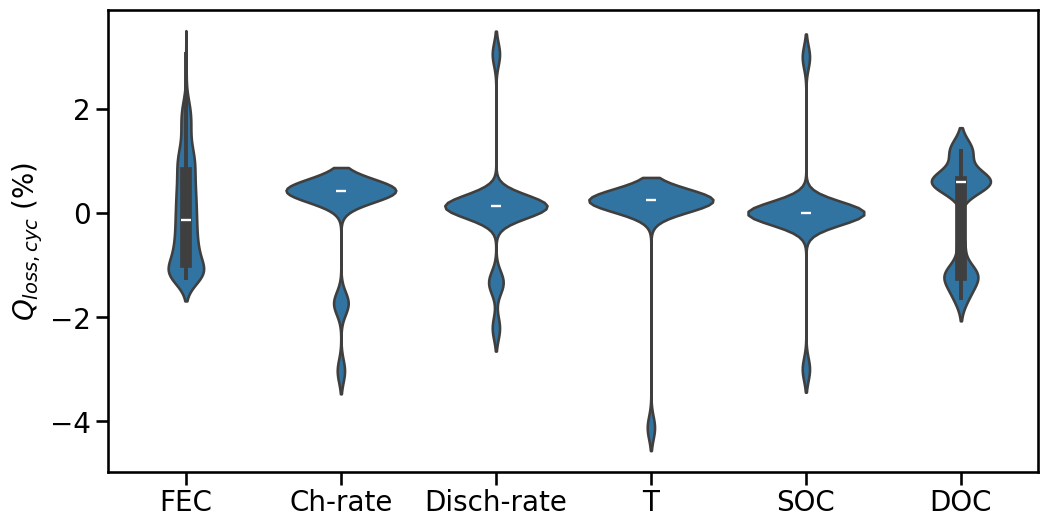

In [7]:
file_name = os.path.join(parent, "results/cycle/figures/violin_cycle.svg")
plot_feature_distributions(cycle_aging.df_train_inverse, type=cycle_aging.degradation_type, save_plot=True, save_path=file_name)

## Training the CycleAging Model

In the following cell, we train the `CycleAging` model using the combined dataset (`df_comb`) and the calendar aging dataset (`df_calendar`). The training process involves preprocessing the data and fitting the model to the data to learn the patterns and relationships between various features (such as cycle counts, temperature, and depth of discharge) and the battery's degradation behavior.

In [8]:
# Training the model
cycle_aging.train(df_comb, df_calendar, is_virtual=False)

Preprocessing data.
Training model with provided data.
Retrieving the neural network.
Epoch 1/100
12312/12312 [==============================] - 20s 2ms/step - loss: 2.9053
Epoch 2/100
 2232/12312 [====>.........................] - ETA: 16s - loss: 1.7234

KeyboardInterrupt: 

## Making Predictions on Battery Capacity Loss with CycleAging Model

In the following cell, we use the trained `CycleAging` model to predict battery capacity loss (`Q_loss (%)`). The process involves several steps:

1. **Feature Preparation**: We start by normalizing and preparing the input features required for prediction.
2. **Prediction**: The prepared features are passed through the probabilistic model, which provides predictions in terms of both mean and standard deviation, allowing us to capture uncertainty in the predictions.
3. **Result Integration**: The predicted mean values and their confidence intervals (±2 standard deviations) are added to the DataFrame. These predictions will help in analyzing how the model estimates battery aging under various conditions and how confident the model is in its predictions.

This step is crucial for understanding the model's performance and the reliability of its predictions.


In [9]:
features_normalized = cycle_aging.df_inverse_scaled[cycle_aging.df_inverse_scaled.drop(columns=['Q_loss (%)']).columns.tolist()]
features_array = features_normalized.to_numpy()
features_reshaped = np.expand_dims(features_array, axis=1)
predictions = cycle_aging.model_prob(features_reshaped)
flatten_layer = tf.keras.layers.Flatten()
predictions_mean = predictions.mean()
predictions_sd = predictions.stddev()
cycle_aging.df_inverse['Q_loss_predicted (%)'] = flatten_layer(predictions_mean)
cycle_aging.df_inverse['Q_loss_predicted_m2sd (%)'] = flatten_layer(predictions_mean - 2*predictions_sd)
cycle_aging.df_inverse['Q_loss_predicted_p2sd (%)'] = flatten_layer(predictions_mean + 2*predictions_sd)

## Plotting Battery Capacity Loss for a Specific Static Condition with Confidence Intervals

In the following cell, we select a specific set of operating static conditions from the dataset and plot the battery capacity loss over time (in terms of Full Equivalent Cycles, FEC). The selected conditions include specific charge and discharge rates, temperature, state of charge (SOC), and depth of discharge (DoD).

This visualization helps us evaluate how well the model predicts battery aging under specific conditions and the associated uncertainty. The plot is saved as an SVG file in the `results/cycle/figures/` directory for further analysis or inclusion in reports.

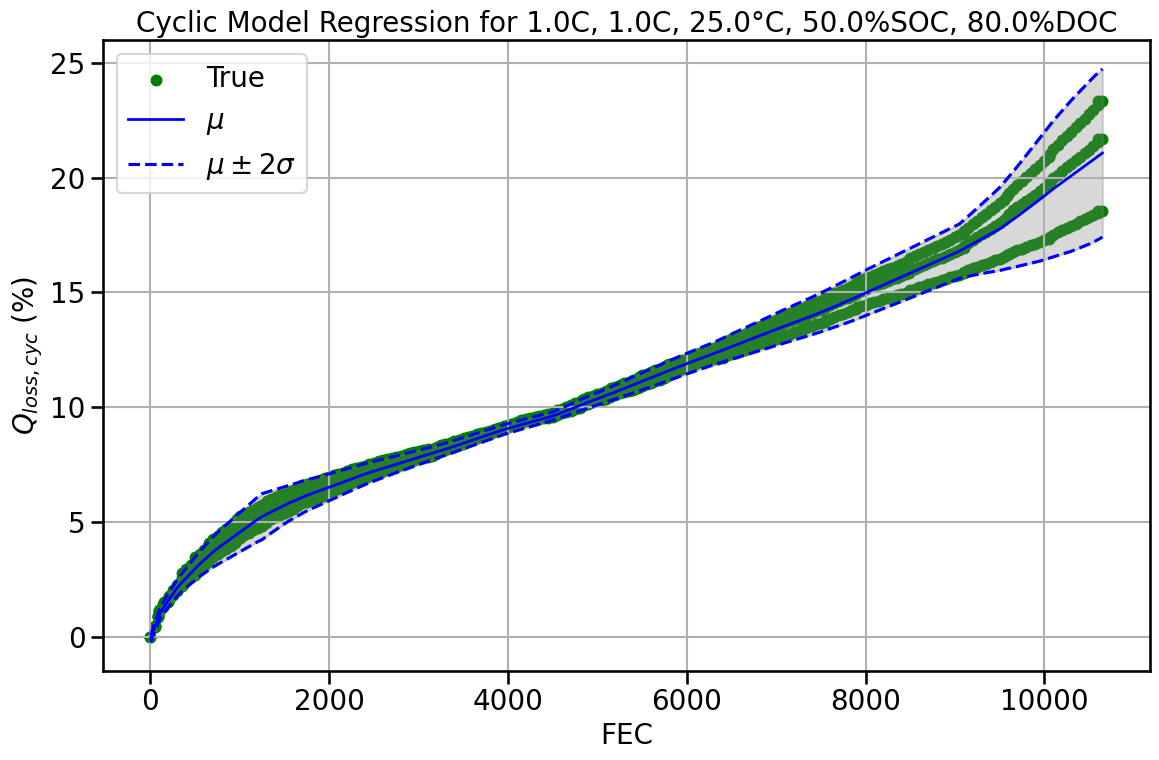

In [10]:
# condition_num = list(test_conditions.keys())[0]
condition_num = 15
condition = cycle_aging.conditions[condition_num]
Charge_rate_selector = cycle_aging.df_inverse['Ch-rate'] == condition[0]
Discharge_rate_selector = cycle_aging.df_inverse['Disch-rate'] == condition[1]
Temperature_selector = cycle_aging.df_inverse['T'] == condition[2]
SOC_selector = cycle_aging.df_inverse['SOC'] == condition[3]
DOD_selector = cycle_aging.df_inverse['DOC'] == condition[4]
name = f'{condition[0]}C, {condition[1]}C, {condition[2]}°C, {condition[3]}%SOC, {condition[4]}%DOC'
name_true = 'True'
name_fitted = '$\mu$'
name_pm2sd = '$\mu \pm 2 \sigma$'
combined_conditions = Charge_rate_selector & Discharge_rate_selector & Temperature_selector & SOC_selector & DOD_selector
x = cycle_aging.df_inverse.loc[combined_conditions, 'FEC']
y_true = cycle_aging.df_inverse.loc[combined_conditions, 'Q_loss (%)']
y_fitted = cycle_aging.df_inverse.loc[combined_conditions, 'Q_loss_predicted (%)']
y_m2sd = cycle_aging.df_inverse.loc[combined_conditions, 'Q_loss_predicted_m2sd (%)']
y_p2sd = cycle_aging.df_inverse.loc[combined_conditions, 'Q_loss_predicted_p2sd (%)']

file_name = os.path.join(parent, "results\cycle", f"figures\static_{name}.svg")
plot_static_loss_with_confidence_intervals(x, y_true, y_fitted, y_m2sd, y_p2sd, name, type=cycle_aging.degradation_type, save_plot=True, save_path=file_name)